#***Classe Agent (Agent d'Apprentissage par Renforcement)***
#Cette classe représente l'agent qui apprend à jouer au jeu Snake en utilisant l'apprentissage par renforcement avec Q-Learning

***1. Importations***

torch : Utilisé pour le réseau de neurones et les calculs matriciels avec PyTorch.

 random : Permet d'introduire une exploration aléatoire dans le choix des actions.

numpy : Utilisé pour manipuler des tableaux et transformer les états en format numérique.

 deque : Structure de file double pour stocker les expériences de l’agent et permettre un entraînement basé sur l'expérience passée.

snake : Fichier contenant la logique du jeu Snake :

    SnakeGameAI : Classe principale du jeu.

    Direction : Enumération pour représenter les directions.

    Point : Représente les coordonnées dans le jeu.

 Deep_Q-Network(DQN) : Contient le réseau de neurones et la fonction d'entraînement :

    Linear_QNet : Réseau de neurones qui apprend à jouer.

    QTrainer : Algorithme d’optimisation basé sur le Q-Learning.

show : Contient la fonction plot(), utilisée pour afficher l’évolution des scores.


In [ ]:
'''
import torch
import random
import numpy as np
from collections import deque
from snake import SnakeGameAI, Direction, Point
from Deep_Q-Network(DQN) import Linear_QNet, QTrainer
from show import plot
'''

***2. Paramètres globaux***

 MAX_MEMORY : Nombre maximal d’expériences stockées en mémoire.

BATCH_SIZE : Nombre d’échantillons utilisés à chaque entraînement.

LR : Taux d’apprentissage du réseau de neurones.

In [ ]:
'''
MAX_MEMORY = 100_000
BATCH_SIZE = 1000
LR = 0.001
'''

***3. Classe Agent***

Cette classe définit l'agent intelligent qui apprend à jouer au jeu Snake.



In [ ]:
'''
class Agent:
'''

***3.1. Initialisation***

 self.n_games : Compteur du nombre de parties jouées.

self.epsilon : Contrôle l'exploration (prises de décisions aléatoires).

 self.gamma : Facteur de réduction du Q-Learning (impact des récompenses futures).

self.memory : Liste FIFO stockant les expériences.

self.model : Réseau de neurones avec 11 entrées, 256 neurones cachés et 3 sorties.

 self.trainer : Optimiseur basé sur Q-Learning.



In [ ]:
'''
def __init__(self):
    self.n_games = 0
    self.epsilon = 0 # randomness
    self.gamma = 0.9 # discount rate
    self.memory = deque(maxlen=MAX_MEMORY) # popleft()
    self.model = Linear_QNet(11, 256, 3)
    self.trainer = QTrainer(self.model, lr=LR, gamma=self.gamma)

'''

***3.2. Extraction de l'état du jeu***

Cette fonction retourne un vecteur d’état représentant la situation actuelle du jeu.


Détermine les coordonnées de la tête du serpent.

Définit quatre points autour de la tête (gauche, droite, haut, bas).


 Vérifie la direction actuelle du serpent.

Danger immédiat (collision devant, à gauche, à droite).

  Direction actuelle du serpent.

 Position relative de la nourriture.



In [ ]:
'''
def get_state(self, game):
  head = game.snake[0]
  point_l = Point(head.x - 20, head.y)
  point_r = Point(head.x + 20, head.y)
  point_u = Point(head.x, head.y - 20)
  point_d = Point(head.x, head.y + 20)
  dir_l = game.direction == Direction.LEFT
  dir_r = game.direction == Direction.RIGHT
  dir_u = game.direction == Direction.UP
  dir_d = game.direction == Direction.DOWN
  state = [
      (dir_r and game.is_collision(point_r)) or
      (dir_l and game.is_collision(point_l)) or
      (dir_u and game.is_collision(point_u)) or
      (dir_d and game.is_collision(point_d)),

      (dir_u and game.is_collision(point_r)) or
      (dir_d and game.is_collision(point_l)) or
      (dir_l and game.is_collision(point_u)) or
      (dir_r and game.is_collision(point_d)),

      (dir_d and game.is_collision(point_r)) or
      (dir_u and game.is_collision(point_l)) or
      (dir_r and game.is_collision(point_u)) or
      (dir_l and game.is_collision(point_d)),

      dir_l,
      dir_r,
      dir_u,
      dir_d,

      game.food.x < game.head.x,
      game.food.x > game.head.x,
      game.food.y < game.head.y,
      game.food.y > game.head.y
  ]

'''

***3.3. Mémorisation des expériences***

Stocke une expérience pour un entraînement futur.




In [ ]:
'''
def remember(self, state, action, reward, next_state, done):
    self.memory.append((state, action, reward, next_state, done))

'''

***3.4. Entraînement à long et court terme***

Sélectionne un mini-batch d’expériences.

Entraîne le modèle sur cet échantillon.

Entraîne immédiatement l’agent sur une seule expérience.



In [ ]:
'''
    def train_long_memory(self):
        if len(self.memory) > BATCH_SIZE:
            mini_sample = random.sample(self.memory, BATCH_SIZE) # list of tuples
        else:
            mini_sample = self.memory

        states, actions, rewards, next_states, dones = zip(*mini_sample)
        self.trainer.train_step(states, actions, rewards, next_states, dones)
        #for state, action, reward, nexrt_state, done in mini_sample:
        #    self.trainer.train_step(state, action, reward, next_state, done)

    def train_short_memory(self, state, action, reward, next_state, done):
        self.trainer.train_step(state, action, reward, next_state, done)



'''

***3.5. Choix de l’action***

L’agent décide s’il explore ou exploite

 Exploration : Si random < epsilon, l’agent choisit une action aléatoire.

 Exploitation : Sinon, il prédit la meilleure action avec son modèle.



In [ ]:
'''
def get_action(self, state):
  self.epsilon = 80 - self.n_games
  final_move = [0,0,0]
  if random.randint(0, 200) < self.epsilon:
      move = random.randint(0, 2)
  else:
      state0 = torch.tensor(state, dtype=torch.float)
      prediction = self.model(state0)
      move = torch.argmax(prediction).item()
  final_move[move] = 1
  return final_move

'''

***4. Fonction train()***
Cette fonction gère l’entraînement complet :

Initialise l’agent et le jeu.

Récupère l’état, effectue un mouvement, et obtient la récompense.

Entraînement court terme et mémorisation.

Fin de partie : entraînement à long terme.

Sauvegarde du meilleur modèle.



In [8]:
'''
def train():
    plot_scores = []
    plot_mean_scores = []
    total_score = 0
    record = 0
    agent = Agent()
    game = SnakeGameAI()
    while True:
        # get old state
        state_old = agent.get_state(game)

        # get move
        final_move = agent.get_action(state_old)

        # perform move and get new state
        reward, done, score = game.play_step(final_move)
        state_new = agent.get_state(game)

        # train short memory
        agent.train_short_memory(state_old, final_move, reward, state_new, done)

        # remember
        agent.remember(state_old, final_move, reward, state_new, done)

        if done:
            # train long memory, plot result
            game.reset()
            agent.n_games += 1
            agent.train_long_memory()

            if score > record:
                record = score
                agent.model.save()

            print('Game', agent.n_games, 'Score', score, 'Record:', record)

            plot_scores.append(score)
            total_score += score
            mean_score = total_score / agent.n_games
            plot_mean_scores.append(mean_score)
            plot(plot_scores, plot_mean_scores)


if __name__ == '__main__':
    train()
'''

"\ndef train():\n    plot_scores = []\n    plot_mean_scores = []\n    total_score = 0\n    record = 0\n    agent = Agent()\n    game = SnakeGameAI()\n    while True:\n        # get old state\n        state_old = agent.get_state(game)\n\n        # get move\n        final_move = agent.get_action(state_old)\n\n        # perform move and get new state\n        reward, done, score = game.play_step(final_move)\n        state_new = agent.get_state(game)\n\n        # train short memory\n        agent.train_short_memory(state_old, final_move, reward, state_new, done)\n\n        # remember\n        agent.remember(state_old, final_move, reward, state_new, done)\n\n        if done:\n            # train long memory, plot result\n            game.reset()\n            agent.n_games += 1\n            agent.train_long_memory()\n\n            if score > record:\n                record = score\n                agent.model.save()\n\n            print('Game', agent.n_games, 'Score', score, 'Record:', recor

<Figure size 640x480 with 0 Axes>

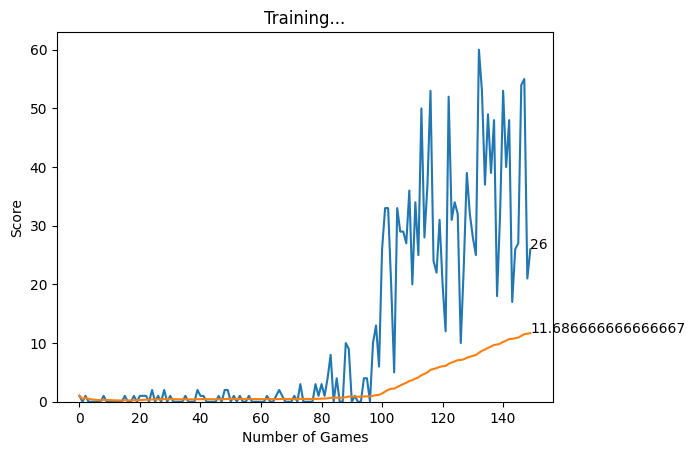

Training completed after 150 games.


In [22]:
import torch
import random
import sys
import numpy as np
from collections import deque

sys.path.append('/content/drive/MyDrive/Colab_Notebooks/')

from snake import SnakeGameAI, Direction, Point
from Deep_Q-Network(DQN) import Linear_QNet, QTrainer
from show import plot  # Ensure helper.py is correctly named and located

# Constants
MAX_MEMORY = 100_000
BATCH_SIZE = 1000
LR = 0.001

class Agent:
    def __init__(self):
        self.n_games = 0
        self.epsilon = 0  # randomness
        self.gamma = 0.9  # discount rate
        self.memory = deque(maxlen=MAX_MEMORY)  # popleft() when full
        self.model = Linear_QNet(11, 256, 3)
        self.trainer = QTrainer(self.model, lr=LR, gamma=self.gamma)

    def get_state(self, game):
        head = game.snake[0]
        point_l = Point(head.x - 20, head.y)
        point_r = Point(head.x + 20, head.y)
        point_u = Point(head.x, head.y - 20)
        point_d = Point(head.x, head.y + 20)

        dir_l = game.direction == Direction.LEFT
        dir_r = game.direction == Direction.RIGHT
        dir_u = game.direction == Direction.UP
        dir_d = game.direction == Direction.DOWN

        state = [
            # Danger straight
            (dir_r and game.is_collision(point_r)) or
            (dir_l and game.is_collision(point_l)) or
            (dir_u and game.is_collision(point_u)) or
            (dir_d and game.is_collision(point_d)),

            # Danger right
            (dir_u and game.is_collision(point_r)) or
            (dir_d and game.is_collision(point_l)) or
            (dir_l and game.is_collision(point_u)) or
            (dir_r and game.is_collision(point_d)),

            # Danger left
            (dir_d and game.is_collision(point_r)) or
            (dir_u and game.is_collision(point_l)) or
            (dir_r and game.is_collision(point_u)) or
            (dir_l and game.is_collision(point_d)),

            # Move direction
            dir_l,
            dir_r,
            dir_u,
            dir_d,

            # Food location
            game.food.x < game.head.x,  # food left
            game.food.x > game.head.x,  # food right
            game.food.y < game.head.y,  # food up
            game.food.y > game.head.y  # food down
        ]

        return np.array(state, dtype=int)

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))  # popleft if MAX_MEMORY is reached

    def train_long_memory(self):
        if len(self.memory) > BATCH_SIZE:
            mini_sample = random.sample(self.memory, BATCH_SIZE)  # list of tuples
        else:
            mini_sample = self.memory

        states, actions, rewards, next_states, dones = zip(*mini_sample)
        self.trainer.train_step(states, actions, rewards, next_states, dones)

    def train_short_memory(self, state, action, reward, next_state, done):
        self.trainer.train_step(state, action, reward, next_state, done)

    def get_action(self, state):
        # Random moves: tradeoff between exploration & exploitation
        self.epsilon = 80 - self.n_games
        final_move = [0, 0, 0]

        if random.randint(0, 200) < self.epsilon:
            move = random.randint(0, 2)
            final_move[move] = 1
        else:
            state0 = torch.tensor(state, dtype=torch.float)
            prediction = self.model(state0)
            move = torch.argmax(prediction).item()
            final_move[move] = 1

        return final_move


def train():
    plot_scores = []
    plot_mean_scores = []
    total_score = 0
    record = 0
    agent = Agent()
    game = SnakeGameAI()

    while agent.n_games < 150:  # Stop after 150 games
        # Get old state
        state_old = agent.get_state(game)

        # Get move
        final_move = agent.get_action(state_old)

        # Perform move and get new state
        reward, done, score = game.play_step(final_move)
        state_new = agent.get_state(game)

        # Train short memory
        agent.train_short_memory(state_old, final_move, reward, state_new, done)

        # Remember
        agent.remember(state_old, final_move, reward, state_new, done)

        if done:
            # Train long memory, plot result
            game.reset()
            agent.n_games += 1
            agent.train_long_memory()

            if score > record:
                record = score
                agent.model.save()

            print(f'Game {agent.n_games}, Score: {score}, Record: {record}')

            plot_scores.append(score)
            total_score += score
            mean_score = total_score / agent.n_games
            plot_mean_scores.append(mean_score)
            plot(plot_scores, plot_mean_scores)

    print("Training completed after 150 games.")

if __name__ == '__main__':
    train()
